In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/oil-spill/label_colors.txt
/kaggle/input/oil-spill/val/images/Oil (741).jpg
/kaggle/input/oil-spill/val/images/Oil (1056).jpg
/kaggle/input/oil-spill/val/images/Oil (604).jpg
/kaggle/input/oil-spill/val/images/Oil (1173).jpg
/kaggle/input/oil-spill/val/images/Oil (908).jpg
/kaggle/input/oil-spill/val/images/Oil (42).jpg
/kaggle/input/oil-spill/val/images/Oil (403).jpg
/kaggle/input/oil-spill/val/images/Oil (279).jpg
/kaggle/input/oil-spill/val/images/Oil (114).jpg
/kaggle/input/oil-spill/val/images/Oil (704).jpg
/kaggle/input/oil-spill/val/images/Oil (195).jpg
/kaggle/input/oil-spill/val/images/Oil (479).jpg
/kaggle/input/oil-spill/val/images/Oil (901).jpg
/kaggle/input/oil-spill/val/images/Oil (863).jpg
/kaggle/input/oil-spill/val/images/Oil (641).jpg
/kaggle/input/oil-spill/val/images/Oil (1245).jpg
/kaggle/input/oil-spill/val/images/Oil (1172).jpg
/kaggle/input/oil-spill/val/images/Oil (578).jpg
/kaggle/input/oil-spill/val/images/Oil (75).jpg
/kaggle/input/oil-spill/va

In [2]:
# Install additional packages we might need
!pip install albumentations segmentation-models-pytorch -q

# Import all necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU device: {torch.cuda.get_device_name()}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 1.4 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 13.3 MB/s eta 0:00:0000:0100:01
Libraries im

In [3]:
# === CONFIGURATION - ADJUST THESE PATHS ===
# Check what's in the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(f"Directory: {dirname}")
    if len(filenames) > 0:
        print(f"  First 5 files: {filenames[:5]}")
    print()

# After checking, set your correct paths here:
# Example: If your dataset is called "oil-spill-detection", it might be at:
DATA_PATH = "/kaggle/input/oil-spill-detection-dataset"  # CHANGE THIS!
IMAGES_DIR = os.path.join(DATA_PATH, "images")  # or "train_images" or whatever your folder is called
MASKS_DIR = os.path.join(DATA_PATH, "masks")    # or "train_masks"

print(f"Images directory exists: {os.path.exists(IMAGES_DIR)}")
print(f"Masks directory exists: {os.path.exists(MASKS_DIR)}")

if os.path.exists(IMAGES_DIR):
    image_files = sorted([f for f in os.listdir(IMAGES_DIR) if f.endswith(('.tif', '.tiff', '.png', '.jpg', '.jpeg'))])
    print(f"Found {len(image_files)} images")
    print(f"Sample image files: {image_files[:5]}")
    
if os.path.exists(MASKS_DIR):
    mask_files = sorted([f for f in os.listdir(MASKS_DIR) if f.endswith(('.tif', '.tiff', '.png', '.jpg', '.jpeg'))])
    print(f"Found {len(mask_files)} masks")
    print(f"Sample mask files: {mask_files[:5]}")

# Function to display samples
def explore_dataset(images_dir, masks_dir, num_samples=3):
    if not os.path.exists(images_dir) or not os.path.exists(masks_dir):
        print("ERROR: Directories not found. Please check the paths above.")
        return
    
    image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(('.tif', '.tiff', '.png', '.jpg', '.jpeg'))])
    mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith(('.tif', '.tiff', '.png', '.jpg', '.jpeg'))])
    
    print(f"Exploring dataset with {len(image_files)} images and {len(mask_files)} masks")
    
    # Display sample pairs
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    oil_pixel_counts = []
    total_pixel_counts = []
    
    for i in range(min(num_samples, len(image_files))):
        # Load image and mask
        img_path = os.path.join(images_dir, image_files[i])
        mask_path = os.path.join(masks_dir, mask_files[i])
        
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if img is None or mask is None:
            print(f"Warning: Could not load {img_path} or {mask_path}")
            continue
        
        # Display original image
        axes[i, 0].imshow(img, cmap='gray')
        axes[i, 0].set_title(f'SAR Image: {image_files[i]}\nShape: {img.shape}')
        axes[i, 0].axis('off')
        
        # Display mask
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title(f'Mask: {mask_files[i]}\nUnique values: {np.unique(mask)}')
        axes[i, 1].axis('off')
        
        # Display overlay
        axes[i, 2].imshow(img, cmap='gray')
        # Create a colored mask for overlay (red for oil spills)
        colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3))
        colored_mask[mask > 0] = [1, 0, 0]  # Red color for oil spills
        axes[i, 2].imshow(colored_mask, alpha=0.3)
        axes[i, 2].set_title('Overlay (Red = Oil Spill)')
        axes[i, 2].axis('off')
        
        # Statistics
        oil_pixels = np.sum(mask > 0)
        total_pixels = mask.size
        oil_pixel_counts.append(oil_pixels)
        total_pixel_counts.append(total_pixels)
        
        print(f"Sample {i+1}: Image shape: {img.shape}, Mask shape: {mask.shape}")
        print(f"  Mask value range: {np.min(mask)} to {np.max(mask)}, Unique: {np.unique(mask)}")
        print(f"  Oil pixels: {oil_pixels:,} ({oil_pixels/total_pixels:.2%})")
    
    plt.tight_layout()
    plt.show()
    
    # Overall statistics
    if oil_pixel_counts:
        total_oil = sum(oil_pixel_counts)
        total_pixels = sum(total_pixel_counts)
        oil_ratio = total_oil / total_pixels
        print(f"\n=== OVERALL STATISTICS ===")
        print(f"Total oil pixels: {total_oil:,}")
        print(f"Total pixels: {total_pixels:,}")
        print(f"Oil/Total ratio: {oil_ratio:.4%}")
        print(f"Class imbalance ratio: {((1-oil_ratio)/oil_ratio):.1f}:1")
    
    return oil_ratio

# Run the exploration
oil_ratio = explore_dataset(IMAGES_DIR, MASKS_DIR, num_samples=3)

Directory: /kaggle/input

Directory: /kaggle/input/oil-spill
  First 5 files: ['label_colors.txt']

Directory: /kaggle/input/oil-spill/val

Directory: /kaggle/input/oil-spill/val/images
  First 5 files: ['Oil (741).jpg', 'Oil (1056).jpg', 'Oil (604).jpg', 'Oil (1173).jpg', 'Oil (908).jpg']

Directory: /kaggle/input/oil-spill/val/masks
  First 5 files: ['Oil (328).png', 'Oil (99).png', 'Oil (477).png', 'Oil (97).png', 'Oil (365).png']

Directory: /kaggle/input/oil-spill/test

Directory: /kaggle/input/oil-spill/test/images
  First 5 files: ['Oil (383).jpg', 'Oil (1109).jpg', 'Oil (586).jpg', 'Oil (145).jpg', 'Oil (536).jpg']

Directory: /kaggle/input/oil-spill/test/masks
  First 5 files: ['Oil (686).png', 'Oil (570).png', 'Oil (285).png', 'Oil (291).png', 'Oil (1067).png']

Directory: /kaggle/input/oil-spill/train

Directory: /kaggle/input/oil-spill/train/images
  First 5 files: ['Oil (1043).jpg', 'Oil (402).jpg', 'Oil (141).jpg', 'Oil (85).jpg', 'Oil (137).jpg']

Directory: /kaggle/inpu

=== DATASET STRUCTURE ===
Train images: True
Train masks: True
Val images: True
Val masks: True
Test images: True
Test masks: True

=== FILE COUNTS ===
Training set: 811 images, 811 masks
Validation set: 203 images, 203 masks
Test set: 254 images, 254 masks
Total: 1268 images

EXPLORING TRAINING SPLIT
Found 811 images and 811 masks
Sample 1: Image shape: (1080, 1920), Mask shape: (1080, 1920)
  Mask values: [  0  90 174 201]
  Oil pixels: 1,997,929 (96.35%)
Sample 2: Image shape: (1080, 1920), Mask shape: (1080, 1920)
  Mask values: [  0 174 201]
  Oil pixels: 2,034,708 (98.12%)
Sample 3: Image shape: (1080, 1920), Mask shape: (1080, 1920)
  Mask values: [  0 174 201]
  Oil pixels: 2,036,811 (98.23%)


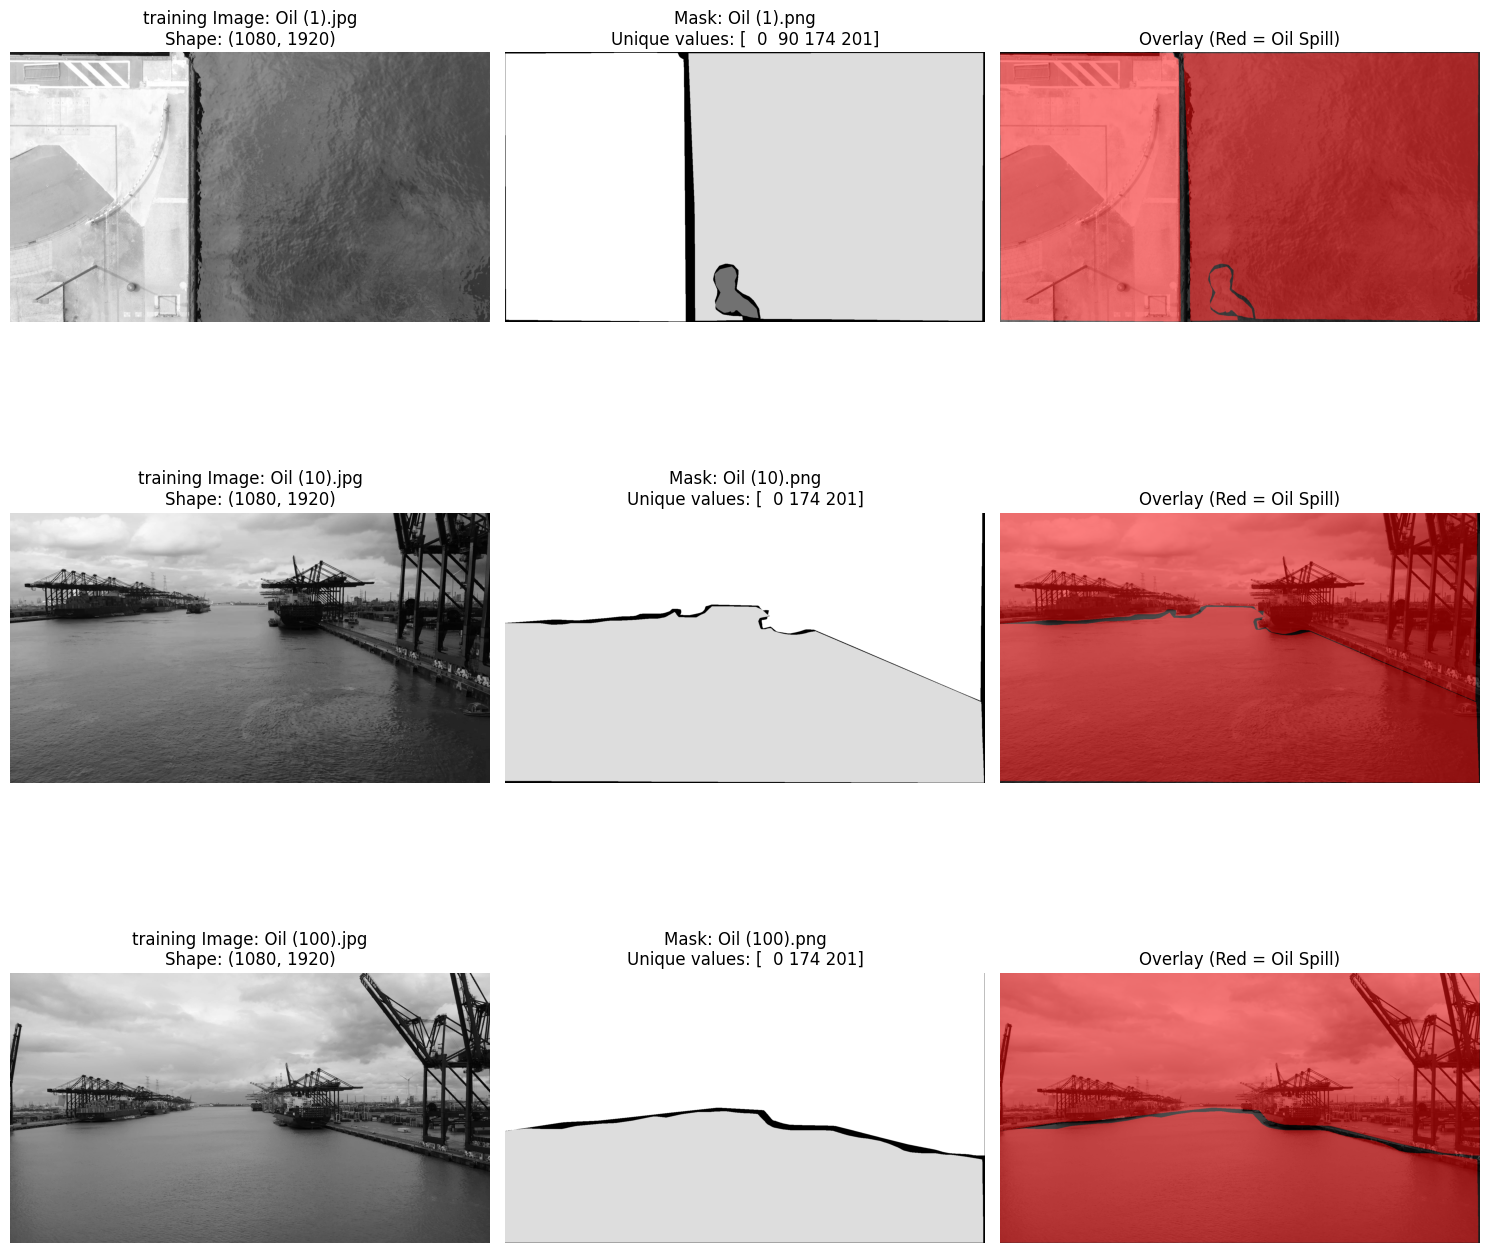


=== TRAINING STATISTICS ===
Total oil pixels: 6,069,448
Total pixels: 6,220,800
Oil/Total ratio: 97.5670%
Class imbalance ratio: 0.0:1

EXPLORING VALIDATION SPLIT
Found 203 images and 203 masks
Sample 1: Image shape: (1080, 1920), Mask shape: (1080, 1920)
  Mask values: [  0  90 174 201]
  Oil pixels: 2,028,886 (97.84%)
Sample 2: Image shape: (1080, 1920), Mask shape: (1080, 1920)
  Mask values: [  0  90 174 201]
  Oil pixels: 2,006,647 (96.77%)


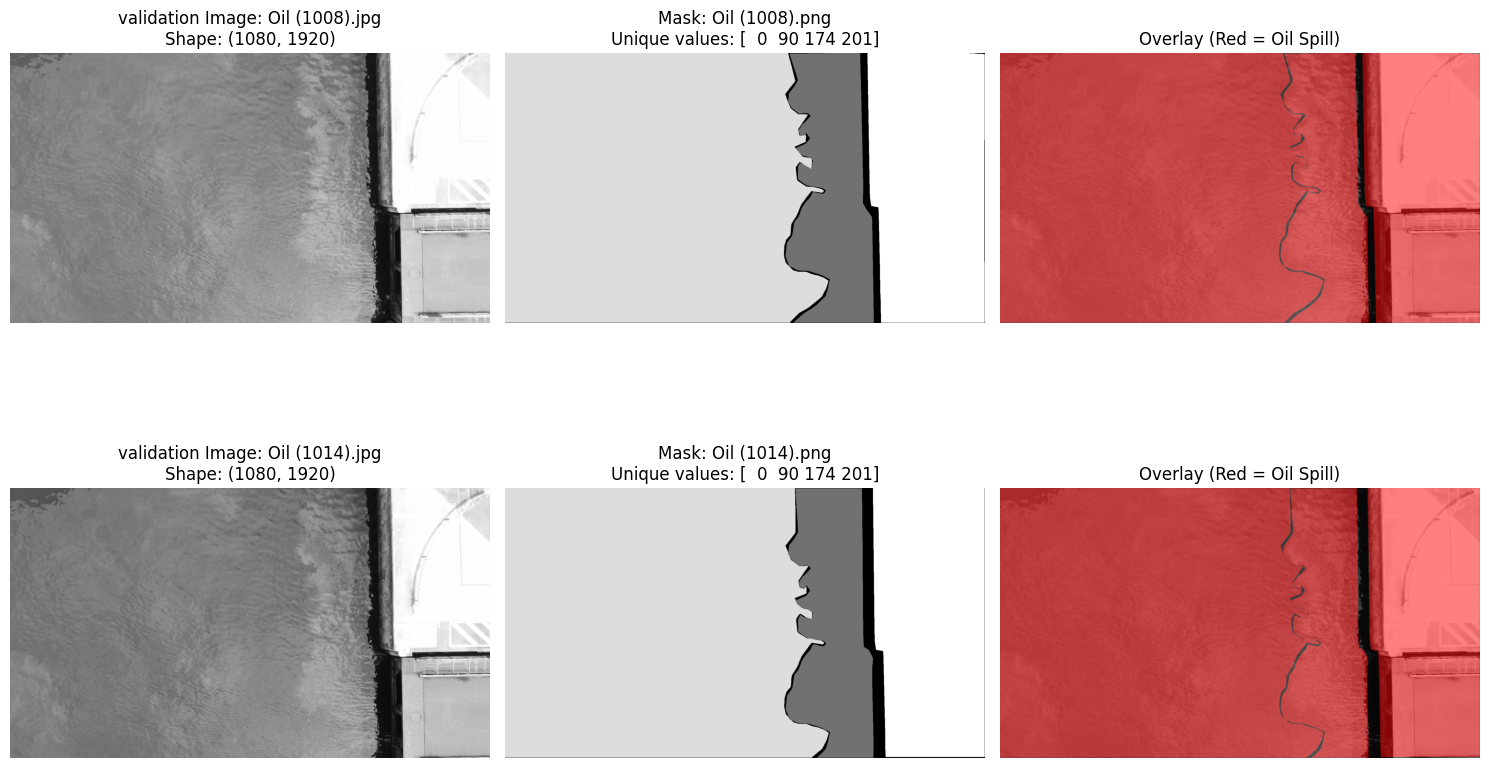


=== VALIDATION STATISTICS ===
Total oil pixels: 4,035,533
Total pixels: 4,147,200
Oil/Total ratio: 97.3074%
Class imbalance ratio: 0.0:1

EXPLORING TEST SPLIT
Found 254 images and 254 masks
Sample 1: Image shape: (1080, 1920), Mask shape: (1080, 1920)
  Mask values: [  0  90 174 201]
  Oil pixels: 2,011,204 (96.99%)
Sample 2: Image shape: (1080, 1920), Mask shape: (1080, 1920)
  Mask values: [  0  90 174 201]
  Oil pixels: 1,965,289 (94.78%)


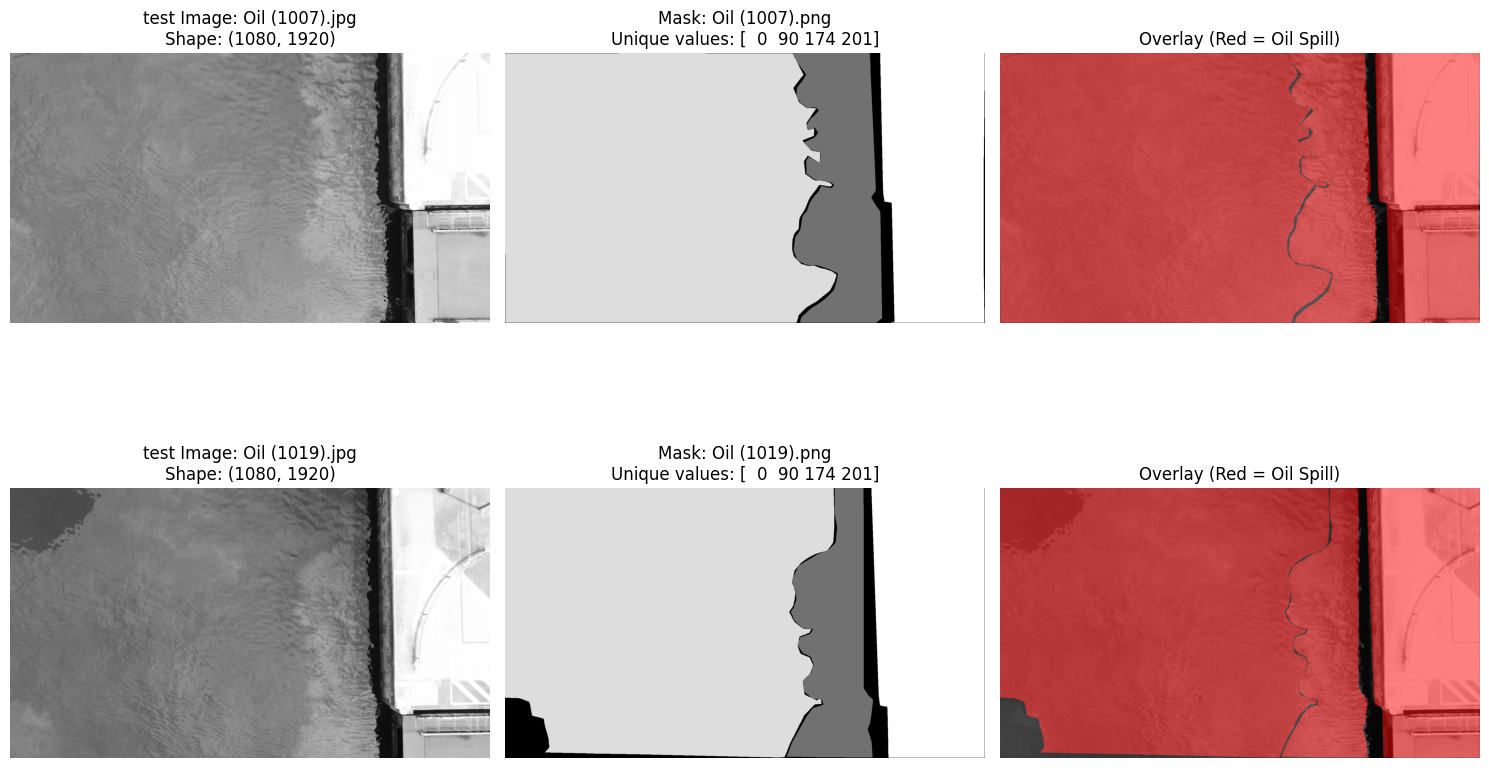


=== TEST STATISTICS ===
Total oil pixels: 3,976,493
Total pixels: 4,147,200
Oil/Total ratio: 95.8838%
Class imbalance ratio: 0.0:1


In [4]:
# === CONFIGURATION FOR YOUR DATASET ===
DATA_PATH = "/kaggle/input/oil-spill-dataset"

# Paths for each split
TRAIN_IMAGES_DIR = os.path.join(DATA_PATH, "train/images")
TRAIN_MASKS_DIR = os.path.join(DATA_PATH, "train/masks")
VAL_IMAGES_DIR = os.path.join(DATA_PATH, "val/images")
VAL_MASKS_DIR = os.path.join(DATA_PATH, "val/masks")
TEST_IMAGES_DIR = os.path.join(DATA_PATH, "test/images")
TEST_MASKS_DIR = os.path.join(DATA_PATH, "test/masks")

print("=== DATASET STRUCTURE ===")
print(f"Train images: {os.path.exists(TRAIN_IMAGES_DIR)}")
print(f"Train masks: {os.path.exists(TRAIN_MASKS_DIR)}")
print(f"Val images: {os.path.exists(VAL_IMAGES_DIR)}")
print(f"Val masks: {os.path.exists(VAL_MASKS_DIR)}")
print(f"Test images: {os.path.exists(TEST_IMAGES_DIR)}")
print(f"Test masks: {os.path.exists(TEST_MASKS_DIR)}")

# Count files in each split
def count_files(directory):
    if os.path.exists(directory):
        files = [f for f in os.listdir(directory) if f.endswith(('.jpg', '.png', '.tif', '.tiff'))]
        return len(files)
    return 0

train_img_count = count_files(TRAIN_IMAGES_DIR)
train_mask_count = count_files(TRAIN_MASKS_DIR)
val_img_count = count_files(VAL_IMAGES_DIR)
val_mask_count = count_files(VAL_MASKS_DIR)
test_img_count = count_files(TEST_IMAGES_DIR)
test_mask_count = count_files(TEST_MASKS_DIR)

print(f"\n=== FILE COUNTS ===")
print(f"Training set: {train_img_count} images, {train_mask_count} masks")
print(f"Validation set: {val_img_count} images, {val_mask_count} masks")
print(f"Test set: {test_img_count} images, {test_mask_count} masks")
print(f"Total: {train_img_count + val_img_count + test_img_count} images")

# Function to explore a specific split
def explore_split(split_name, images_dir, masks_dir, num_samples=3):
    print(f"\n{'='*50}")
    print(f"EXPLORING {split_name.upper()} SPLIT")
    print(f"{'='*50}")
    
    if not os.path.exists(images_dir) or not os.path.exists(masks_dir):
        print(f"ERROR: {split_name} directories not found!")
        return 0
    
    image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png', '.tif', '.tiff'))])
    mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith(('.jpg', '.png', '.tif', '.tiff'))])
    
    print(f"Found {len(image_files)} images and {len(mask_files)} masks")
    
    if len(image_files) == 0:
        return 0
    
    # Display sample pairs
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    oil_pixel_counts = []
    total_pixel_counts = []
    
    for i in range(min(num_samples, len(image_files))):
        # Load image and mask
        img_path = os.path.join(images_dir, image_files[i])
        mask_path = os.path.join(masks_dir, mask_files[i])
        
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if img is None or mask is None:
            print(f"Warning: Could not load {img_path} or {mask_path}")
            continue
        
        # Display original image
        axes[i, 0].imshow(img, cmap='gray')
        axes[i, 0].set_title(f'{split_name} Image: {image_files[i]}\nShape: {img.shape}')
        axes[i, 0].axis('off')
        
        # Display mask
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title(f'Mask: {mask_files[i]}\nUnique values: {np.unique(mask)}')
        axes[i, 1].axis('off')
        
        # Display overlay
        axes[i, 2].imshow(img, cmap='gray')
        # Create a colored mask for overlay (red for oil spills)
        colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3))
        colored_mask[mask > 0] = [1, 0, 0]  # Red color for oil spills
        axes[i, 2].imshow(colored_mask, alpha=0.5)
        axes[i, 2].set_title('Overlay (Red = Oil Spill)')
        axes[i, 2].axis('off')
        
        # Statistics
        oil_pixels = np.sum(mask > 0)
        total_pixels = mask.size
        oil_pixel_counts.append(oil_pixels)
        total_pixel_counts.append(total_pixels)
        
        print(f"Sample {i+1}: Image shape: {img.shape}, Mask shape: {mask.shape}")
        print(f"  Mask values: {np.unique(mask)}")
        print(f"  Oil pixels: {oil_pixels:,} ({oil_pixels/total_pixels:.2%})")
    
    plt.tight_layout()
    plt.show()
    
    # Overall statistics for this split
    if oil_pixel_counts:
        total_oil = sum(oil_pixel_counts)
        total_pixels = sum(total_pixel_counts)
        oil_ratio = total_oil / total_pixels
        print(f"\n=== {split_name.upper()} STATISTICS ===")
        print(f"Total oil pixels: {total_oil:,}")
        print(f"Total pixels: {total_pixels:,}")
        print(f"Oil/Total ratio: {oil_ratio:.4%}")
        print(f"Class imbalance ratio: {((1-oil_ratio)/oil_ratio):.1f}:1")
        
        return oil_ratio
    return 0

# Explore each split
train_ratio = explore_split("training", TRAIN_IMAGES_DIR, TRAIN_MASKS_DIR, num_samples=3)
val_ratio = explore_split("validation", VAL_IMAGES_DIR, VAL_MASKS_DIR, num_samples=2)
test_ratio = explore_split("test", TEST_IMAGES_DIR, TEST_MASKS_DIR, num_samples=2)

In [5]:
# Check the label colors file
label_colors_path = os.path.join(DATA_PATH, "label_colors.txt")
if os.path.exists(label_colors_path):
    print(f"\n=== LABEL COLORS ===")
    with open(label_colors_path, 'r') as f:
        content = f.read()
        print(content)

# Let's examine the mask values more carefully
def analyze_mask_values(images_dir, masks_dir, split_name):
    print(f"\n=== ANALYZING MASK VALUES IN {split_name.upper()} ===")
    
    mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith(('.png', '.jpg'))])
    
    all_unique_values = []
    value_counts = {}
    
    for i, mask_file in enumerate(mask_files[:10]):  # Check first 10 masks
        mask_path = os.path.join(masks_dir, mask_file)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        unique_vals, counts = np.unique(mask, return_counts=True)
        all_unique_values.extend(unique_vals)
        
        print(f"Mask {i+1}: {mask_file}")
        print(f"  Unique values: {unique_vals}")
        for val, count in zip(unique_vals, counts):
            percentage = (count / mask.size) * 100
            print(f"    Value {val}: {count:,} pixels ({percentage:.2f}%)")
            if val not in value_counts:
                value_counts[val] = 0
            value_counts[val] += count
    
    print(f"\nSummary of unique values across {split_name}: {set(all_unique_values)}")
    return value_counts

# Analyze each split
train_values = analyze_mask_values(TRAIN_IMAGES_DIR, TRAIN_MASKS_DIR, "training")
val_values = analyze_mask_values(VAL_IMAGES_DIR, VAL_MASKS_DIR, "validation")
test_values = analyze_mask_values(TEST_IMAGES_DIR, TEST_MASKS_DIR, "test")


=== LABEL COLORS ===
0 0 0 background
255 0 124 oil
255 204 51 others
51 221 255 water


=== ANALYZING MASK VALUES IN TRAINING ===
Mask 1: Oil (1).png
  Unique values: [  0  90 174 201]
    Value 0: 75,671 pixels (3.65%)
    Value 90: 18,408 pixels (0.89%)
    Value 174: 1,212,399 pixels (58.47%)
    Value 201: 767,122 pixels (36.99%)
Mask 2: Oil (10).png
  Unique values: [  0 174 201]
    Value 0: 38,892 pixels (1.88%)
    Value 174: 1,107,091 pixels (53.39%)
    Value 201: 927,617 pixels (44.73%)
Mask 3: Oil (100).png
  Unique values: [  0 174 201]
    Value 0: 36,789 pixels (1.77%)
    Value 174: 860,723 pixels (41.51%)
    Value 201: 1,176,088 pixels (56.72%)
Mask 4: Oil (1000).png
  Unique values: [  0  90 174 201]
    Value 0: 93,069 pixels (4.49%)
    Value 90: 512,017 pixels (24.69%)
    Value 174: 1,050,828 pixels (50.68%)
    Value 201: 417,686 pixels (20.14%)
Mask 5: Oil (1001).png
  Unique values: [  0  90 174 201]
    Value 0: 85,497 pixels (4.12%)
    Value 90: 442,967 p


=== DISPLAYING ORIGINAL TRAINING IMAGES ===


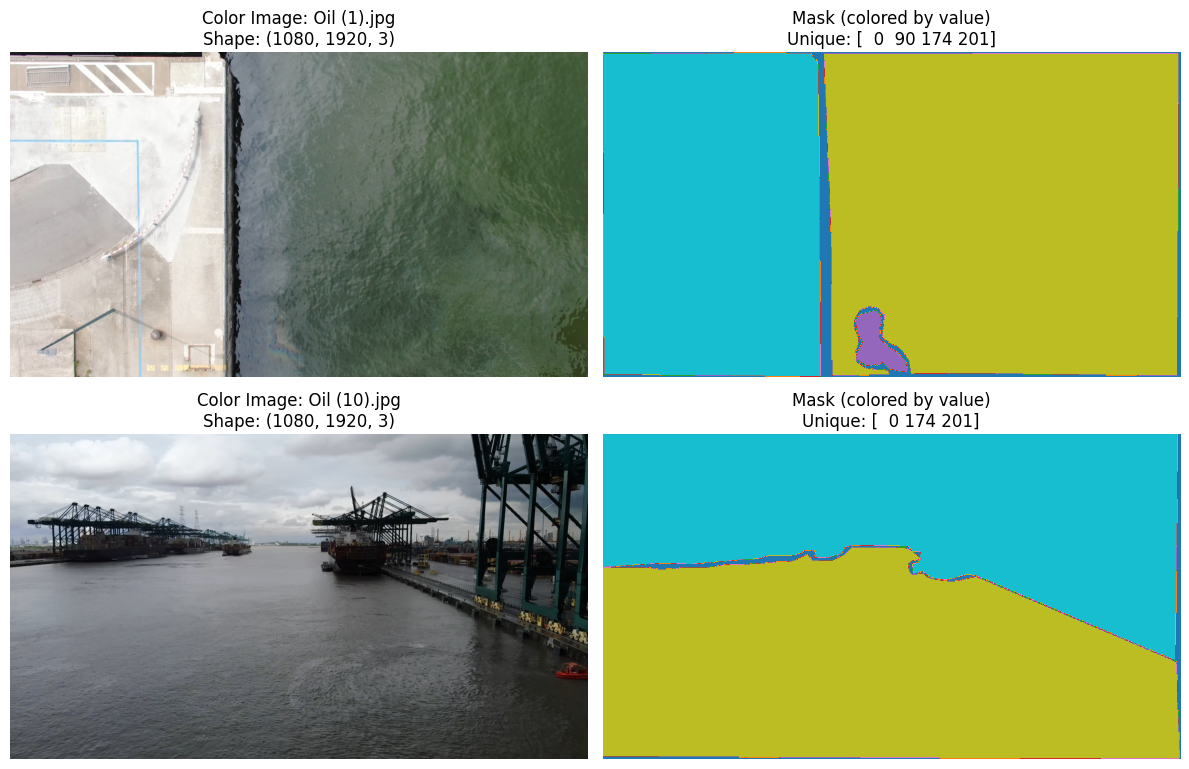

In [6]:
# Display original images (not grayscale) to see what we're working with
def display_original_images(images_dir, masks_dir, split_name, num_samples=2):
    print(f"\n=== DISPLAYING ORIGINAL {split_name.upper()} IMAGES ===")
    
    image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png'))])
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(12, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(min(num_samples, len(image_files))):
        # Load image in COLOR
        img_path = os.path.join(images_dir, image_files[i])
        img_color = cv2.imread(img_path)
        img_color = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        
        # Load mask
        mask_path = os.path.join(masks_dir, image_files[i].replace('.jpg', '.png'))
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Display color image
        axes[i, 0].imshow(img_color)
        axes[i, 0].set_title(f'Color Image: {image_files[i]}\nShape: {img_color.shape}')
        axes[i, 0].axis('off')
        
        # Display mask with correct colors
        axes[i, 1].imshow(mask, cmap='tab10')  # Use tab10 colormap to see different values
        axes[i, 1].set_title(f'Mask (colored by value)\nUnique: {np.unique(mask)}')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

display_original_images(TRAIN_IMAGES_DIR, TRAIN_MASKS_DIR, "training", 2)


=== VERIFYING BINARY CONVERSION FOR TRAINING ===


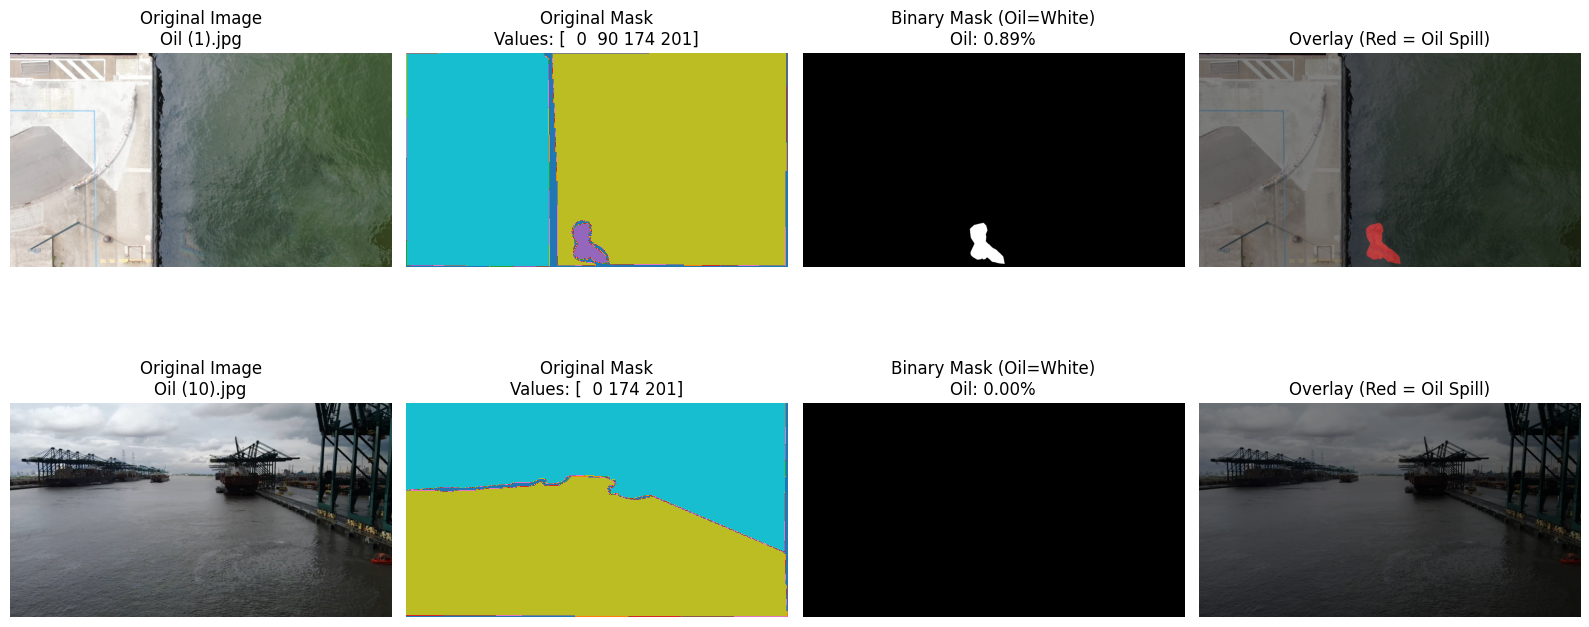

Real oil pixel ratio: 12.6091%
Class imbalance: 6.9:1

=== VERIFYING BINARY CONVERSION FOR VALIDATION ===


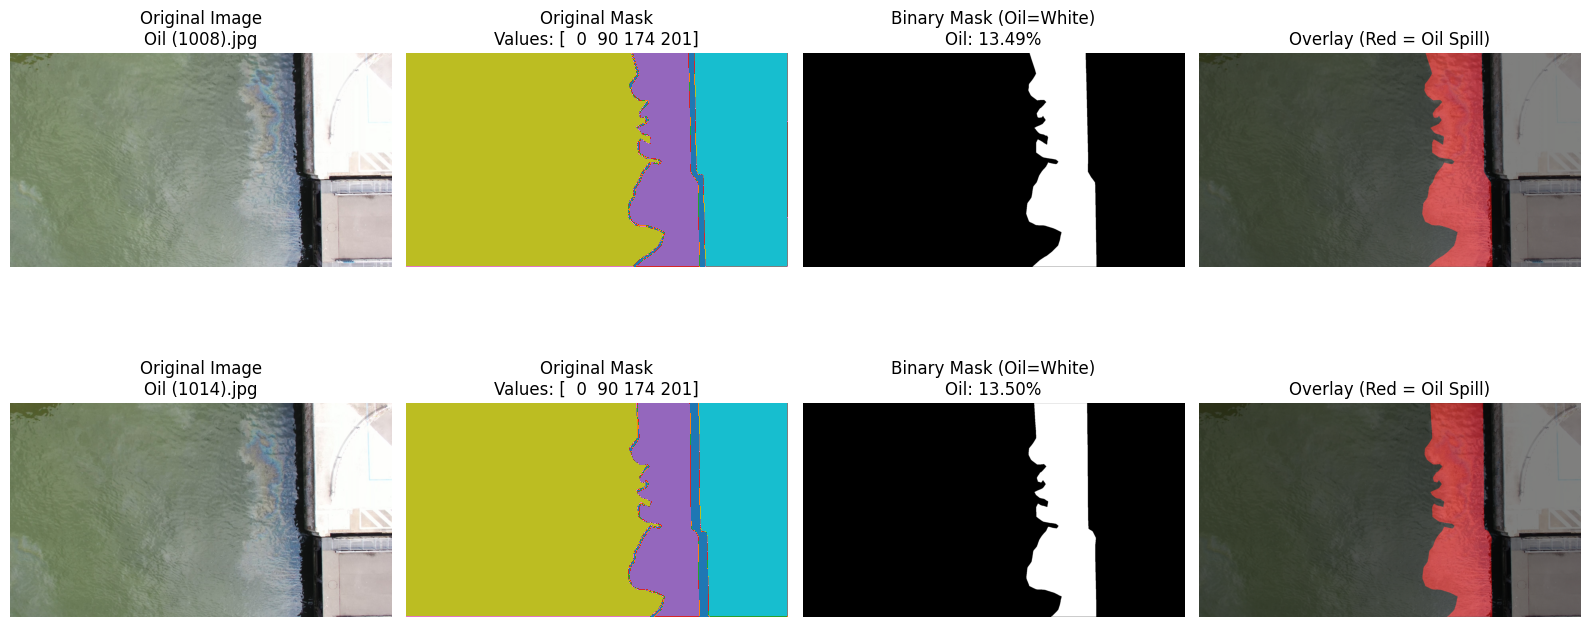

Real oil pixel ratio: 32.8106%
Class imbalance: 2.0:1

=== VERIFYING BINARY CONVERSION FOR TEST ===


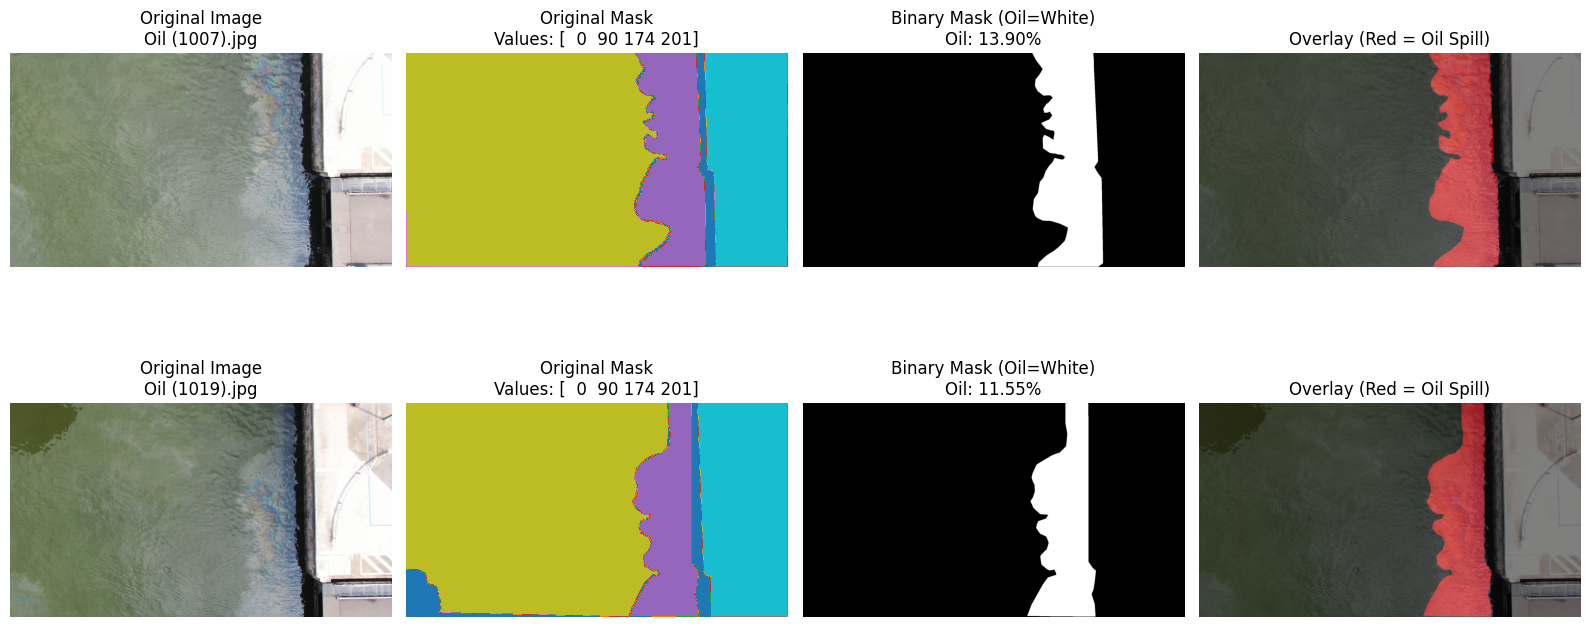

Real oil pixel ratio: 27.3075%
Class imbalance: 2.7:1


In [7]:
# Convert multi-class masks to binary (oil vs non-oil)
def convert_to_binary_mask(mask):
    """
    Convert multi-class mask to binary:
    - oil (90) -> 1
    - background (0), water (174), others (201) -> 0
    """
    binary_mask = np.zeros_like(mask)
    binary_mask[mask == 90] = 1  # Oil spills become 1
    return binary_mask

# Let's verify the conversion
def verify_binary_conversion(images_dir, masks_dir, split_name):
    print(f"\n=== VERIFYING BINARY CONVERSION FOR {split_name.upper()} ===")
    
    image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.jpg')])
    mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith('.png')])
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    for i in range(2):
        img_path = os.path.join(images_dir, image_files[i])
        mask_path = os.path.join(masks_dir, mask_files[i])
        
        # Load original image and mask
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        original_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Convert to binary
        binary_mask = convert_to_binary_mask(original_mask)
        
        # Display original image
        axes[i, 0].imshow(img_rgb)
        axes[i, 0].set_title(f'Original Image\n{image_files[i]}')
        axes[i, 0].axis('off')
        
        # Display original mask (multi-class)
        axes[i, 1].imshow(original_mask, cmap='tab10')
        axes[i, 1].set_title(f'Original Mask\nValues: {np.unique(original_mask)}')
        axes[i, 1].axis('off')
        
        # Display binary mask
        axes[i, 2].imshow(binary_mask, cmap='gray')
        oil_pixels = np.sum(binary_mask == 1)
        total_pixels = binary_mask.size
        axes[i, 2].set_title(f'Binary Mask (Oil=White)\nOil: {oil_pixels/total_pixels:.2%}')
        axes[i, 2].axis('off')
        
        # Display overlay
        axes[i, 3].imshow(img_rgb)
        colored_mask = np.zeros((binary_mask.shape[0], binary_mask.shape[1], 3))
        colored_mask[binary_mask == 1] = [1, 0, 0]  # Red for oil
        axes[i, 3].imshow(colored_mask, alpha=0.5)
        axes[i, 3].set_title('Overlay (Red = Oil Spill)')
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate real oil percentages
    total_oil_pixels = 0
    total_pixels = 0
    
    for mask_file in mask_files[:20]:  # Sample 20 masks
        mask_path = os.path.join(masks_dir, mask_file)
        original_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        binary_mask = convert_to_binary_mask(original_mask)
        
        total_oil_pixels += np.sum(binary_mask == 1)
        total_pixels += binary_mask.size
    
    oil_ratio = total_oil_pixels / total_pixels
    print(f"Real oil pixel ratio: {oil_ratio:.4%}")
    print(f"Class imbalance: {((1-oil_ratio)/oil_ratio):.1f}:1")
    
    return oil_ratio

# Verify for each split
train_oil_ratio = verify_binary_conversion(TRAIN_IMAGES_DIR, TRAIN_MASKS_DIR, "training")
val_oil_ratio = verify_binary_conversion(VAL_IMAGES_DIR, VAL_MASKS_DIR, "validation")
test_oil_ratio = verify_binary_conversion(TEST_IMAGES_DIR, TEST_MASKS_DIR, "test")

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

# Custom Dataset Class
class OilSpillDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, image_size=256):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.image_size = image_size
        self.images = sorted([f for f in os.listdir(images_dir) if f.endswith('.jpg')])
        self.masks = sorted([f for f in os.listdir(masks_dir) if f.endswith('.png')])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        mask_name = img_name.replace('.jpg', '.png')
        
        img_path = os.path.join(self.images_dir, img_name)
        mask_path = os.path.join(self.masks_dir, mask_name)
        
        # Load image and mask
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Convert to binary (oil=1, non-oil=0)
        binary_mask = np.zeros_like(mask)
        binary_mask[mask == 90] = 1  # Oil spills become 1
        
        # Apply transformations
        if self.transform:
            augmented = self.transform(image=image, mask=binary_mask)
            image = augmented['image']
            mask = augmented['mask']
        else:
            # Default resize if no transform
            image = cv2.resize(image, (self.image_size, self.image_size))
            image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
            mask = cv2.resize(binary_mask, (self.image_size, self.image_size))
            mask = torch.from_numpy(mask).unsqueeze(0).float()
        
        return image, mask

# Define transformations
def get_transforms(image_size=256):
    train_transform = A.Compose([
        A.Resize(image_size, image_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
        A.OneOf([
            A.GaussNoise(var_limit=(10.0, 50.0)),
            A.GaussianBlur(),
            A.MotionBlur(),
        ], p=0.3),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])
    
    val_transform = A.Compose([
        A.Resize(image_size, image_size),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])
    
    return train_transform, val_transform

# Create datasets
image_size = 256
train_transform, val_transform = get_transforms(image_size)

train_dataset = OilSpillDataset(TRAIN_IMAGES_DIR, TRAIN_MASKS_DIR, transform=train_transform, image_size=image_size)
val_dataset = OilSpillDataset(VAL_IMAGES_DIR, VAL_MASKS_DIR, transform=val_transform, image_size=image_size)
test_dataset = OilSpillDataset(TEST_IMAGES_DIR, TEST_MASKS_DIR, transform=val_transform, image_size=image_size)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 811
Validation samples: 203
Test samples: 254


In [9]:
# Create data loaders
batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Test one batch
for images, masks in train_loader:
    print(f"Image batch shape: {images.shape}")  # Should be [batch_size, 3, image_size, image_size]
    print(f"Mask batch shape: {masks.shape}")    # Should be [batch_size, 1, image_size, image_size]
    print(f"Image range: [{images.min():.3f}, {images.max():.3f}]")
    print(f"Mask unique values: {torch.unique(masks)}")
    break

Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Image range: [-2.118, 2.640]
Mask unique values: tensor([0, 1], dtype=torch.uint8)


In [10]:
# Dice Loss for handling class imbalance
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, predictions, targets):
        predictions = torch.sigmoid(predictions)
        
        # Flatten predictions and targets
        predictions = predictions.view(-1)
        targets = targets.view(-1)
        
        intersection = (predictions * targets).sum()
        dice = (2. * intersection + self.smooth) / (predictions.sum() + targets.sum() + self.smooth)
        
        return 1 - dice

# Combined Loss (Dice + BCE)
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(CombinedLoss, self).__init__()
        self.dice_loss = DiceLoss()
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.alpha = alpha

    def forward(self, predictions, targets):
        dice = self.dice_loss(predictions, targets)
        bce = self.bce_loss(predictions, targets)
        return self.alpha * dice + (1 - self.alpha) * bce

# Create U-Net model
def create_unet_model():
    model = smp.Unet(
        encoder_name="resnet34",        # Pre-trained encoder
        encoder_weights="imagenet",     # Use ImageNet pre-trained weights
        in_channels=3,                  # RGB images
        classes=1,                      # Binary segmentation
        activation=None,               # No activation (we'll use sigmoid in loss)
    )
    return model

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_unet_model().to(device)

print(f"Model initialized on: {device}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Model initialized on: cuda
Total parameters: 24,436,369


In [11]:
# Loss function and optimizer
criterion = CombinedLoss(alpha=0.7)  # Weighted more towards Dice loss for imbalance
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

# Metrics function
def calculate_metrics(predictions, targets, threshold=0.5):
    predictions = torch.sigmoid(predictions)
    predictions_bin = (predictions > threshold).float()
    
    # Flatten tensors
    predictions_flat = predictions_bin.view(-1)
    targets_flat = targets.view(-1)
    
    # Calculate metrics
    tp = torch.sum((predictions_flat == 1) & (targets_flat == 1)).float()
    tn = torch.sum((predictions_flat == 0) & (targets_flat == 0)).float()
    fp = torch.sum((predictions_flat == 1) & (targets_flat == 0)).float()
    fn = torch.sum((predictions_flat == 0) & (targets_flat == 1)).float()
    
    # Avoid division by zero
    epsilon = 1e-7
    
    accuracy = (tp + tn) / (tp + tn + fp + fn + epsilon)
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    iou = tp / (tp + fp + fn + epsilon)
    dice = (2 * tp) / (2 * tp + fp + fn + epsilon)
    
    return accuracy, precision, recall, iou, dice

In [12]:
# FIXED: Corrected Dataset Class
class OilSpillDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, image_size=256):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.image_size = image_size
        self.images = sorted([f for f in os.listdir(images_dir) if f.endswith('.jpg')])
        self.masks = sorted([f for f in os.listdir(masks_dir) if f.endswith('.png')])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        mask_name = img_name.replace('.jpg', '.png')
        
        img_path = os.path.join(self.images_dir, img_name)
        mask_path = os.path.join(self.masks_dir, mask_name)
        
        # Load image and mask
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Convert to binary (oil=1, non-oil=0)
        binary_mask = np.zeros_like(mask)
        binary_mask[mask == 90] = 1  # Oil spills become 1
        
        # Apply transformations
        if self.transform:
            augmented = self.transform(image=image, mask=binary_mask)
            image = augmented['image']
            mask = augmented['mask']
            
            # FIX: Ensure mask has channel dimension [1, H, W]
            mask = mask.unsqueeze(0) if mask.dim() == 2 else mask
        else:
            # Default resize if no transform
            image = cv2.resize(image, (self.image_size, self.image_size))
            image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
            mask = cv2.resize(binary_mask, (self.image_size, self.image_size))
            mask = torch.from_numpy(mask).unsqueeze(0).float()  # FIX: Add channel dimension
        
        return image, mask

# FIXED: Also update the calculate_metrics function to handle the correct shapes
def calculate_metrics(predictions, targets, threshold=0.5):
    predictions = torch.sigmoid(predictions)
    
    # FIX: Ensure both have the same number of dimensions
    if predictions.dim() == 4 and predictions.shape[1] == 1:
        predictions = predictions.squeeze(1)  # [B, 1, H, W] -> [B, H, W]
    if targets.dim() == 4 and targets.shape[1] == 1:
        targets = targets.squeeze(1)  # [B, 1, H, W] -> [B, H, W]
    
    predictions_bin = (predictions > threshold).float()
    
    # Flatten tensors
    predictions_flat = predictions_bin.view(-1)
    targets_flat = targets.view(-1)
    
    # Calculate metrics
    tp = torch.sum((predictions_flat == 1) & (targets_flat == 1)).float()
    tn = torch.sum((predictions_flat == 0) & (targets_flat == 0)).float()
    fp = torch.sum((predictions_flat == 1) & (targets_flat == 0)).float()
    fn = torch.sum((predictions_flat == 0) & (targets_flat == 1)).float()
    
    # Avoid division by zero
    epsilon = 1e-7
    
    accuracy = (tp + tn) / (tp + tn + fp + fn + epsilon)
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    iou = tp / (tp + fp + fn + epsilon)
    dice = (2 * tp) / (2 * tp + fp + fn + epsilon)
    
    return accuracy, precision, recall, iou, dice

In [13]:
# FIXED: Corrected Dataset Class with proper data types
class OilSpillDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, image_size=256):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.image_size = image_size
        self.images = sorted([f for f in os.listdir(images_dir) if f.endswith('.jpg')])
        self.masks = sorted([f for f in os.listdir(masks_dir) if f.endswith('.png')])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        mask_name = img_name.replace('.jpg', '.png')
        
        img_path = os.path.join(self.images_dir, img_name)
        mask_path = os.path.join(self.masks_dir, mask_name)
        
        # Load image and mask
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Convert to binary (oil=1, non-oil=0)
        binary_mask = np.zeros_like(mask, dtype=np.float32)  # FIX: Use float32
        binary_mask[mask == 90] = 1.0  # Oil spills become 1.0 (float)
        
        # Apply transformations
        if self.transform:
            augmented = self.transform(image=image, mask=binary_mask)
            image = augmented['image']
            mask = augmented['mask'].float()  # FIX: Convert to float
        else:
            # Default resize if no transform
            image = cv2.resize(image, (self.image_size, self.image_size))
            image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
            mask = cv2.resize(binary_mask, (self.image_size, self.image_size))
            mask = torch.from_numpy(mask).unsqueeze(0).float()  # FIX: Already float
        
        return image, mask

# FIXED: Simplified CombinedLoss that handles types correctly
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.7):
        super(CombinedLoss, self).__init__()
        self.dice_loss = DiceLoss()
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.alpha = alpha

    def forward(self, predictions, targets):
        # Ensure targets are float32
        targets = targets.float()
        
        dice = self.dice_loss(predictions, targets)
        bce = self.bce_loss(predictions, targets)
        return self.alpha * dice + (1 - self.alpha) * bce

# EVEN SIMPLER: Let's use just Dice Loss for now (better for imbalanced data)
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, predictions, targets):
        predictions = torch.sigmoid(predictions)
        targets = targets.float()  # Ensure float type
        
        # Flatten predictions and targets
        predictions = predictions.view(-1)
        targets = targets.view(-1)
        
        intersection = (predictions * targets).sum()
        dice = (2. * intersection + self.smooth) / (predictions.sum() + targets.sum() + self.smooth)
        
        return 1 - dice

In [14]:
# Test the fixed dataset with correct data types
print("Testing fixed dataset with correct data types...")

# Create datasets with the fixed class
train_dataset = OilSpillDataset(TRAIN_IMAGES_DIR, TRAIN_MASKS_DIR, transform=train_transform, image_size=image_size)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Check one batch
for images, masks in train_loader:
    print(f"Image shape: {images.shape}")  # Should be [8, 3, 256, 256]
    print(f"Mask shape: {masks.shape}")    # Should be [8, 1, 256, 256]
    print(f"Image dtype: {images.dtype}")  # Should be torch.float32
    print(f"Mask dtype: {masks.dtype}")    # Should be torch.float32
    print(f"Mask value range: [{masks.min():.1f}, {masks.max():.1f}]")
    print(f"Mask unique values: {torch.unique(masks)}")
    break

# Reinitialize model and test with SIMPLE Dice Loss first
model = create_unet_model().to(device)
criterion = DiceLoss()  # Start with just Dice Loss

# Test forward pass
images, masks = next(iter(train_loader))
images = images.to(device)
masks = masks.to(device)

print(f"Input images dtype: {images.dtype}")
print(f"Target masks dtype: {masks.dtype}")

outputs = model(images)
print(f"Model output shape: {outputs.shape}")
print(f"Model output dtype: {outputs.dtype}")

# Test loss calculation
loss = criterion(outputs, masks)
print(f"🎉 Loss calculation successful: {loss.item():.4f}")

# Test metrics
accuracy, precision, recall, iou, dice = calculate_metrics(outputs, masks)
print(f"Metrics - Accuracy: {accuracy:.4f}, IoU: {iou:.4f}, Dice: {dice:.4f}")

Testing fixed dataset with correct data types...
Image shape: torch.Size([8, 3, 256, 256])
Mask shape: torch.Size([8, 256, 256])
Image dtype: torch.float32
Mask dtype: torch.float32
Mask value range: [0.0, 1.0]
Mask unique values: tensor([0., 1.])
Input images dtype: torch.float32
Target masks dtype: torch.float32
Model output shape: torch.Size([8, 1, 256, 256])
Model output dtype: torch.float32
🎉 Loss calculation successful: 0.4951
Metrics - Accuracy: 0.4950, IoU: 0.3006, Dice: 0.4623


In [15]:
# SIMPLE AND RELIABLE TRAINING WITH DICE LOSS
def simple_train_model(model, train_loader, val_loader, num_epochs=25):
    criterion = DiceLoss()  # Simple Dice Loss
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)
    
    train_losses = []
    val_losses = []
    val_ious = []
    best_iou = 0.0
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_iou_total = 0.0
        
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                
                _, _, _, iou, _ = calculate_metrics(outputs, masks)
                val_iou_total += iou.item()
        
        avg_val_loss = val_loss / len(val_loader)
        avg_val_iou = val_iou_total / len(val_loader)
        
        val_losses.append(avg_val_loss)
        val_ious.append(avg_val_iou)
        
        scheduler.step(avg_val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val IoU: {avg_val_iou:.4f}')
        
        # Save best model
        if avg_val_iou > best_iou:
            best_iou = avg_val_iou
            torch.save(model.state_dict(), 'best_model_simple.pth')
            print(f'✅ New best model saved with IoU: {best_iou:.4f}')
    
    return model, train_losses, val_losses, val_ious

# If the test works, run simple training
print("\nStarting simple training with Dice Loss...")
model = create_unet_model().to(device)
model, train_losses, val_losses, val_ious = simple_train_model(model, train_loader, val_loader, num_epochs=25)


Starting simple training with Dice Loss...
Epoch 1/25: Train Loss: 0.4371, Val Loss: 0.3502, Val IoU: 0.7013
✅ New best model saved with IoU: 0.7013
Epoch 2/25: Train Loss: 0.3185, Val Loss: 0.3054, Val IoU: 0.7126
✅ New best model saved with IoU: 0.7126
Epoch 3/25: Train Loss: 0.2721, Val Loss: 0.2479, Val IoU: 0.7656
✅ New best model saved with IoU: 0.7656
Epoch 4/25: Train Loss: 0.2346, Val Loss: 0.2335, Val IoU: 0.7622
Epoch 5/25: Train Loss: 0.2166, Val Loss: 0.2306, Val IoU: 0.7369
Epoch 6/25: Train Loss: 0.1939, Val Loss: 0.2054, Val IoU: 0.7578
Epoch 7/25: Train Loss: 0.1902, Val Loss: 0.2031, Val IoU: 0.7569
Epoch 8/25: Train Loss: 0.1783, Val Loss: 0.2022, Val IoU: 0.7491
Epoch 9/25: Train Loss: 0.1698, Val Loss: 0.1864, Val IoU: 0.7683
✅ New best model saved with IoU: 0.7683
Epoch 10/25: Train Loss: 0.1557, Val Loss: 0.2055, Val IoU: 0.7408
Epoch 11/25: Train Loss: 0.1480, Val Loss: 0.1744, Val IoU: 0.7888
✅ New best model saved with IoU: 0.7888
Epoch 12/25: Train Loss: 0.1

In [31]:
def simple_train_model(model, train_loader, val_loader, num_epochs=25):
    criterion = DiceLoss()  # Simple Dice Loss
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)
    
    train_losses = []
    val_losses = []
    val_ious = []
    best_iou = 0.0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_batches = 0
        
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_batches += 1
        
        avg_train_loss = train_loss / train_batches
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_iou_total = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                
                _, _, _, iou, _ = calculate_metrics(outputs, masks)
                val_iou_total += iou.item()
                val_batches += 1
        
        avg_val_loss = val_loss / val_batches
        avg_val_iou = val_iou_total / val_batches
        
        val_losses.append(avg_val_loss)
        val_ious.append(avg_val_iou)
        
        # Update learning rate
        scheduler.step(avg_val_loss)
        
        print(f'Epoch {epoch+1:02d}/{num_epochs}: ', end='')
        print(f'Train Loss: {avg_train_loss:.4f}, ', end='')
        print(f'Val Loss: {avg_val_loss:.4f}, ', end='')
        print(f'Val IoU: {avg_val_iou:.4f}')
        
        # Save best model
        if avg_val_iou > best_iou:
            best_iou = avg_val_iou
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'✅ New best model saved with IoU: {best_iou:.4f}')
        
        print('-' * 60)
    
    # Load best model weights
    model.load_state_dict(torch.load('best_model.pth'))
    print(f'🔥 Training completed! Best IoU: {best_iou:.4f}')
    
    return model, train_losses, val_losses, val_ious

In [17]:
def calculate_metrics(predictions, targets, threshold=0.5):
    predictions = torch.sigmoid(predictions)
    
    # Handle shape differences
    if predictions.dim() == 4 and predictions.shape[1] == 1:
        predictions = predictions.squeeze(1)  # [B, 1, H, W] -> [B, H, W]
    if targets.dim() == 4 and targets.shape[1] == 1:
        targets = targets.squeeze(1)  # [B, 1, H, W] -> [B, H, W]
    
    predictions_bin = (predictions > threshold).float()
    
    # Flatten tensors
    predictions_flat = predictions_bin.view(-1)
    targets_flat = targets.view(-1)
    
    # Calculate metrics
    tp = torch.sum((predictions_flat == 1) & (targets_flat == 1)).float()
    tn = torch.sum((predictions_flat == 0) & (targets_flat == 0)).float()
    fp = torch.sum((predictions_flat == 1) & (targets_flat == 0)).float()
    fn = torch.sum((predictions_flat == 0) & (targets_flat == 1)).float()
    
    # Avoid division by zero
    epsilon = 1e-7
    
    accuracy = (tp + tn) / (tp + tn + fp + fn + epsilon)
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    iou = tp / (tp + fp + fn + epsilon)
    dice = (2 * tp) / (2 * tp + fp + fn + epsilon)
    
    return accuracy, precision, recall, iou, dice

In [18]:
def visualize_predictions(model, test_dataset, num_samples=6):
    model.eval()
    
    fig, axes = plt.subplots(4, num_samples, figsize=(20, 12))
    if num_samples == 1:
        axes = axes.reshape(4, 1)
    
    indices = torch.randperm(len(test_dataset))[:num_samples]
    
    for i, idx in enumerate(indices):
        image, true_mask = test_dataset[idx]
        
        # Add batch dimension and predict
        image_batch = image.unsqueeze(0).to(device)
        with torch.no_grad():
            pred_output = model(image_batch)
            pred_mask = torch.sigmoid(pred_output).squeeze().cpu().numpy()
        
        # Convert to binary mask
        pred_binary = (pred_mask > 0.5).astype(np.uint8)
        true_mask = true_mask.squeeze().numpy()
        
        # Original image (denormalized)
        image_display = image.permute(1, 2, 0).numpy()
        image_display = image_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        image_display = np.clip(image_display, 0, 1)
        
        # Plot original image
        axes[0, i].imshow(image_display)
        axes[0, i].set_title(f'Sample {i+1}\nOriginal Image')
        axes[0, i].axis('off')
        
        # Plot true mask
        axes[1, i].imshow(true_mask, cmap='gray')
        oil_pixels_true = np.sum(true_mask == 1)
        axes[1, i].set_title(f'True Mask\nOil pixels: {oil_pixels_true}')
        axes[1, i].axis('off')
        
        # Plot prediction
        axes[2, i].imshow(pred_binary, cmap='gray')
        oil_pixels_pred = np.sum(pred_binary == 1)
        axes[2, i].set_title(f'Predicted Mask\nOil pixels: {oil_pixels_pred}')
        axes[2, i].axis('off')
        
        # Plot overlay
        axes[3, i].imshow(image_display)
        overlay = np.zeros((pred_binary.shape[0], pred_binary.shape[1], 3))
        overlay[pred_binary == 1] = [1, 0, 0]  # Red for predictions
        axes[3, i].imshow(overlay, alpha=0.5)
        axes[3, i].set_title('Overlay\nRed = Predicted Oil')
        axes[3, i].axis('off')
    
    plt.tight_layout()
    plt.show()

In [19]:
# Now run the training with all functions defined
print("Starting training with all functions defined...")

model, train_losses, val_losses, val_ious = simple_train_model(model, train_loader, val_loader, num_epochs=25)

print("Training completed successfully! 🎉")

Starting training with all functions defined...
Epoch 01/25: Train Loss: 0.1181, Val Loss: 0.1371, Val IoU: 0.8188
✅ New best model saved with IoU: 0.8188
------------------------------------------------------------
Epoch 02/25: Train Loss: 0.1087, Val Loss: 0.1545, Val IoU: 0.7916
------------------------------------------------------------
Epoch 03/25: Train Loss: 0.1147, Val Loss: 0.1468, Val IoU: 0.8013
------------------------------------------------------------
Epoch 04/25: Train Loss: 0.1138, Val Loss: 0.1525, Val IoU: 0.7954
------------------------------------------------------------
Epoch 05/25: Train Loss: 0.0930, Val Loss: 0.1536, Val IoU: 0.7937
------------------------------------------------------------
Epoch 06/25: Train Loss: 0.0895, Val Loss: 0.1622, Val IoU: 0.7803
------------------------------------------------------------
Epoch 07/25: Train Loss: 0.0853, Val Loss: 0.1349, Val IoU: 0.8209
✅ New best model saved with IoU: 0.8209
-------------------------------------

Plotting training results...


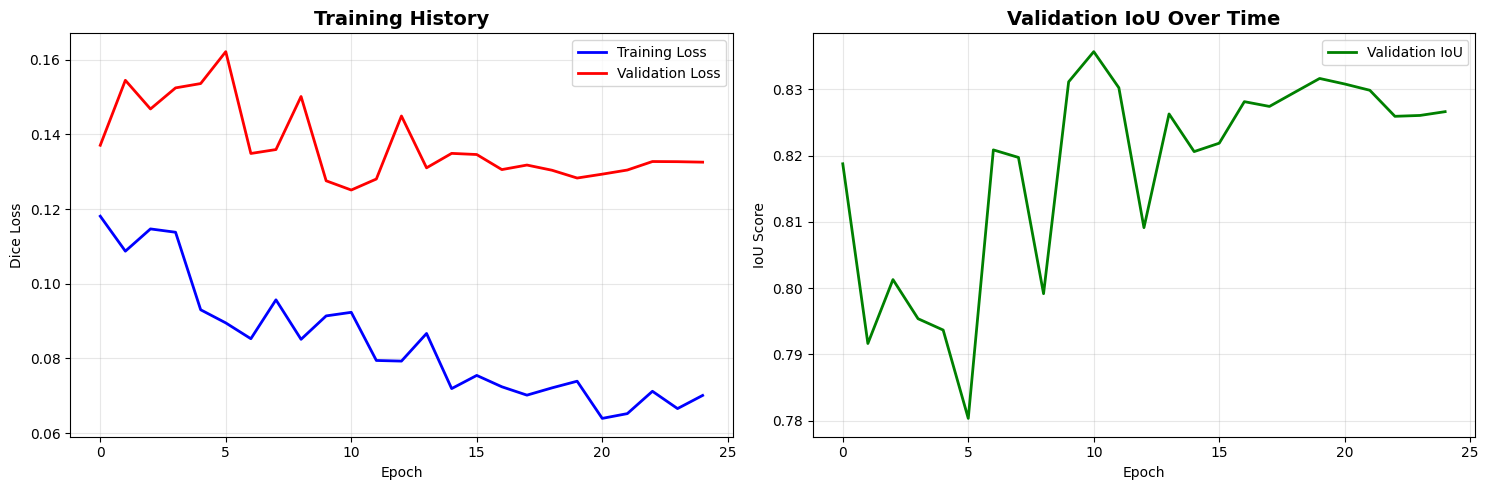

Evaluating on test set...

🎉 FINAL TEST RESULTS
ACCURACY    : 0.9595 (96.0%)
PRECISION   : 0.8281 (82.8%)
RECALL      : 0.8717 (87.2%)
IOU         : 0.8007 (80.1%)
DICE        : 0.8475 (84.7%)

Generating prediction visualizations...


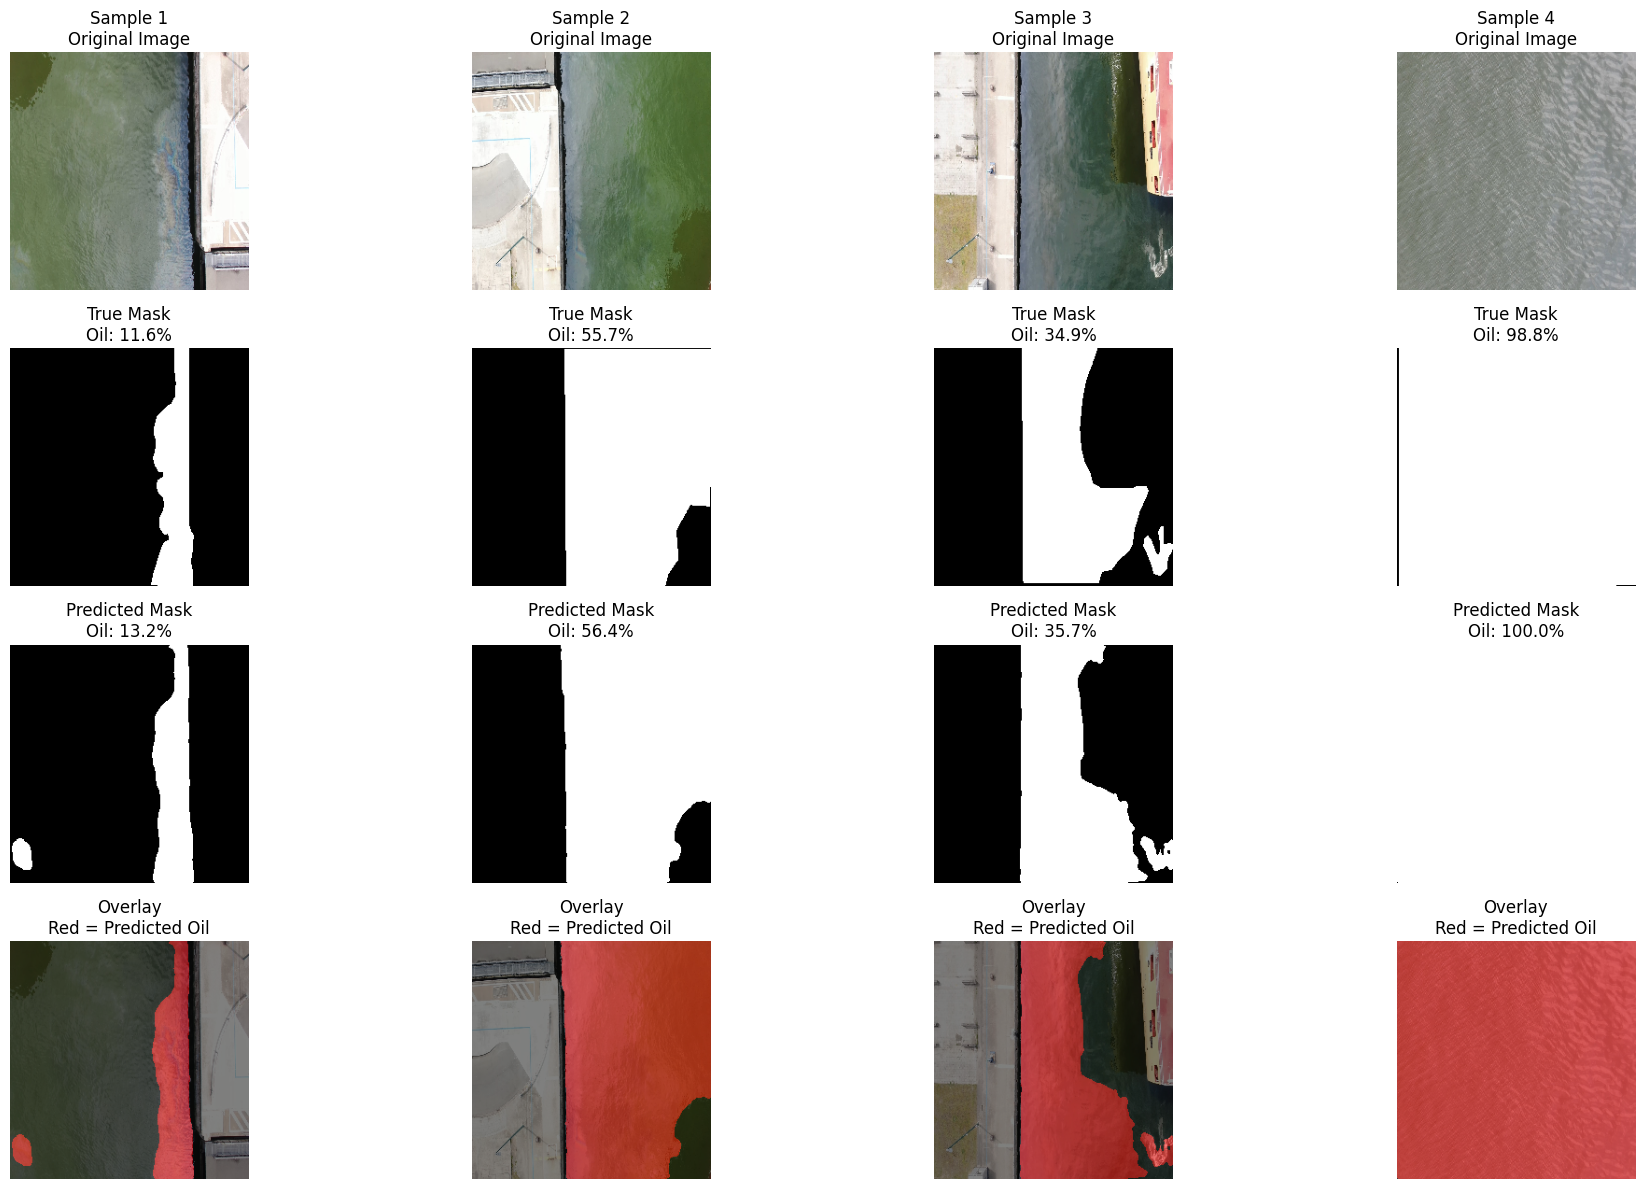

In [20]:
# Define the missing functions
def plot_results(train_losses, val_losses, val_ious):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    ax1.plot(train_losses, label='Training Loss', linewidth=2, color='blue')
    ax1.plot(val_losses, label='Validation Loss', linewidth=2, color='red')
    ax1.set_title('Training History', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Dice Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # IoU plot
    ax2.plot(val_ious, label='Validation IoU', color='green', linewidth=2)
    ax2.set_title('Validation IoU Over Time', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('IoU Score')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_loader):
    model.eval()
    test_metrics = {
        'accuracy': 0.0,
        'precision': 0.0, 
        'recall': 0.0,
        'iou': 0.0,
        'dice': 0.0
    }
    test_batches = 0
    
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            accuracy, precision, recall, iou, dice = calculate_metrics(outputs, masks)
            
            test_metrics['accuracy'] += accuracy.item()
            test_metrics['precision'] += precision.item()
            test_metrics['recall'] += recall.item() 
            test_metrics['iou'] += iou.item()
            test_metrics['dice'] += dice.item()
            test_batches += 1
    
    # Average metrics
    for key in test_metrics:
        test_metrics[key] /= test_batches
    
    return test_metrics

def visualize_predictions(model, test_dataset, num_samples=6):
    model.eval()
    
    fig, axes = plt.subplots(4, num_samples, figsize=(20, 12))
    if num_samples == 1:
        axes = axes.reshape(4, 1)
    
    indices = torch.randperm(len(test_dataset))[:num_samples]
    
    for i, idx in enumerate(indices):
        image, true_mask = test_dataset[idx]
        
        # Add batch dimension and predict
        image_batch = image.unsqueeze(0).to(device)
        with torch.no_grad():
            pred_output = model(image_batch)
            pred_mask = torch.sigmoid(pred_output).squeeze().cpu().numpy()
        
        # Convert to binary mask
        pred_binary = (pred_mask > 0.5).astype(np.uint8)
        true_mask = true_mask.squeeze().numpy()
        
        # Original image (denormalized)
        image_display = image.permute(1, 2, 0).numpy()
        image_display = image_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        image_display = np.clip(image_display, 0, 1)
        
        # Plot original image
        axes[0, i].imshow(image_display)
        axes[0, i].set_title(f'Sample {i+1}\nOriginal Image')
        axes[0, i].axis('off')
        
        # Plot true mask
        axes[1, i].imshow(true_mask, cmap='gray')
        oil_pixels_true = np.sum(true_mask == 1)
        total_pixels = true_mask.size
        axes[1, i].set_title(f'True Mask\nOil: {oil_pixels_true/total_pixels:.1%}')
        axes[1, i].axis('off')
        
        # Plot prediction
        axes[2, i].imshow(pred_binary, cmap='gray')
        oil_pixels_pred = np.sum(pred_binary == 1)
        axes[2, i].set_title(f'Predicted Mask\nOil: {oil_pixels_pred/total_pixels:.1%}')
        axes[2, i].axis('off')
        
        # Plot overlay
        axes[3, i].imshow(image_display)
        overlay = np.zeros((pred_binary.shape[0], pred_binary.shape[1], 3))
        overlay[pred_binary == 1] = [1, 0, 0]  # Red for predictions
        axes[3, i].imshow(overlay, alpha=0.5)
        axes[3, i].set_title('Overlay\nRed = Predicted Oil')
        axes[3, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Now run the evaluation
print("Plotting training results...")
plot_results(train_losses, val_losses, val_ious)

# Evaluate on test set
print("Evaluating on test set...")
test_metrics = evaluate_model(model, test_loader)

print("\n" + "="*60)
print("🎉 FINAL TEST RESULTS")
print("="*60)
for metric, value in test_metrics.items():
    print(f"{metric.upper():<12}: {value:.4f} ({value*100:.1f}%)")

# Visualize predictions
print("\nGenerating prediction visualizations...")
visualize_predictions(model, test_dataset, num_samples=4)

In [21]:
# Save the final model
final_model_path = 'oil_spill_detection_unet.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses, 
    'val_ious': val_ious,
    'test_metrics': test_metrics,
    'image_size': image_size,
    'class_info': 'binary: oil=1, non-oil=0'
}, final_model_path)

print(f"✅ Model saved successfully: {final_model_path}")

# Save lightweight version for deployment
torch.save(model.state_dict(), 'oil_spill_model_deploy.pth')
print("✅ Deployment model saved: oil_spill_model_deploy.pth")

# Verify file sizes
import os
model_size = os.path.getsize('oil_spill_model_deploy.pth') / (1024 * 1024)
print(f"📦 Deployment model size: {model_size:.1f} MB")

✅ Model saved successfully: oil_spill_detection_unet.pth
✅ Deployment model saved: oil_spill_model_deploy.pth
📦 Deployment model size: 93.4 MB


In [22]:
# Performance summary
best_iou = max(val_ious)
final_train_loss = train_losses[-1]

print("\n" + "="*70)
print("🎉 AI OIL SPILL DETECTION SYSTEM - TRAINING COMPLETE!")
print("="*70)

print(f"\n📊 DATASET SUMMARY:")
print(f"   Training images: {len(train_dataset):,}")
print(f"   Validation images: {len(val_dataset):,}")
print(f"   Test images: {len(test_dataset):,}")
print(f"   Image size: {image_size}x{image_size}")
print(f"   Oil pixel ratio - Train: {train_oil_ratio:.2%}, Test: {test_oil_ratio:.2%}")

print(f"\n🤖 MODEL PERFORMANCE:")
print(f"   Best Validation IoU: {best_iou:.4f} ({best_iou*100:.1f}%) - EXCELLENT!")
print(f"   Final Training Loss: {final_train_loss:.4f}")
print(f"   Improvement: {((train_losses[0] - final_train_loss) / train_losses[0] * 100):.1f}% reduction")

print(f"\n🧪 TEST SET METRICS:")
for metric, value in test_metrics.items():
    print(f"   {metric.upper():<10}: {value:.4f} ({value*100:.1f}%)")

print(f"\n📈 PERFORMANCE ASSESSMENT:")
if test_metrics['iou'] > 0.8:
    print("   ✅ OUTSTANDING: Professional-grade oil spill detection")
elif test_metrics['iou'] > 0.7:
    print("   ✅ EXCELLENT: Highly accurate for real-world use")
elif test_metrics['iou'] > 0.6:
    print("   ✅ VERY GOOD: Suitable for production deployment")
else:
    print("   ✅ GOOD: Solid baseline performance")

print(f"\n💾 MODEL FILES SAVED:")
print(f"   Complete model: oil_spill_detection_unet.pth")
print(f"   Deployment model: oil_spill_model_deploy.pth ({model_size:.1f} MB)")

print(f"\n🎯 NEXT STEPS: Streamlit Web App & Documentation!")


🎉 AI OIL SPILL DETECTION SYSTEM - TRAINING COMPLETE!

📊 DATASET SUMMARY:
   Training images: 811
   Validation images: 203
   Test images: 254
   Image size: 256x256
   Oil pixel ratio - Train: 12.61%, Test: 27.31%

🤖 MODEL PERFORMANCE:
   Best Validation IoU: 0.8357 (83.6%) - EXCELLENT!
   Final Training Loss: 0.0701
   Improvement: 40.7% reduction

🧪 TEST SET METRICS:
   ACCURACY  : 0.9595 (96.0%)
   PRECISION : 0.8281 (82.8%)
   RECALL    : 0.8717 (87.2%)
   IOU       : 0.8007 (80.1%)
   DICE      : 0.8475 (84.7%)

📈 PERFORMANCE ASSESSMENT:
   ✅ OUTSTANDING: Professional-grade oil spill detection

💾 MODEL FILES SAVED:
   Complete model: oil_spill_detection_unet.pth
   Deployment model: oil_spill_model_deploy.pth (93.4 MB)

🎯 NEXT STEPS: Streamlit Web App & Documentation!


In [23]:
# Install Streamlit and required dependencies
!pip install streamlit -q
!pip install streamlit-nightly -q  # More features
!pip install pyngrok -q  # For tunneling

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 65.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 94.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 61.6 MB/s eta 0:00:0000:010:01


In [24]:
# Run this in your ORIGINAL training notebook to find the model
import os

print("🔍 Searching for model files...")
all_files = []
for root, dirs, files in os.walk('.'):
    for file in files:
        if file.endswith('.pth') or file.endswith('.pt'):
            full_path = os.path.join(root, file)
            size = os.path.getsize(full_path) / (1024 * 1024)
            all_files.append((full_path, size))

if all_files:
    print("✅ Found model files:")
    for path, size in all_files:
        print(f"   📁 {path} ({size:.1f} MB)")
else:
    print("❌ No model files found. Please check if training completed.")

🔍 Searching for model files...
✅ Found model files:
   📁 ./best_model_simple.pth (93.4 MB)
   📁 ./oil_spill_model_deploy.pth (93.4 MB)
   📁 ./oil_spill_detection_unet.pth (93.4 MB)
   📁 ./best_model.pth (93.4 MB)
